In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline as IMBPipeline
# from sklearn.pipeline import Pipeline
# from sklearn.pipeline import make_pipeline

import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

# Data Preprocessing

In [2]:
# Read in data to DataFrame
df = pd.read_csv('data/features_3_sec.csv').drop(columns=['filename', 'length'])

# Extract feature names and store features in X
features = list(df.columns)[:-1]
X = df[features]

# One-hot encode labels, extract label names, and store labels in y
encoder = OneHotEncoder()
y = encoder.fit_transform(df[['label']]).toarray()
labels = encoder.get_feature_names_out(['label'])

# Partition data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale feature data to have 0 mean and unit variance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# One-hot encode labels within DataFrame
df_encoded = pd.concat([df, pd.get_dummies(df['label'], prefix='label')], axis=1)
df.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.080790e+06,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,6.722448e+05,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,7.907127e+05,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,9.216524e+05,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,6.102111e+05,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


# EDA

In [3]:
# Check data for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 58 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   chroma_stft_mean         9990 non-null   float64
 1   chroma_stft_var          9990 non-null   float64
 2   rms_mean                 9990 non-null   float64
 3   rms_var                  9990 non-null   float64
 4   spectral_centroid_mean   9990 non-null   float64
 5   spectral_centroid_var    9990 non-null   float64
 6   spectral_bandwidth_mean  9990 non-null   float64
 7   spectral_bandwidth_var   9990 non-null   float64
 8   rolloff_mean             9990 non-null   float64
 9   rolloff_var              9990 non-null   float64
 10  zero_crossing_rate_mean  9990 non-null   float64
 11  zero_crossing_rate_var   9990 non-null   float64
 12  harmony_mean             9990 non-null   float64
 13  harmony_var              9990 non-null   float64
 14  perceptr_mean           

In [4]:
# Turns out there is no missing values, so check descriptive statistics
df.describe()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
count,9990.000000,9990.000000,9990.000000,9.990000e+03,9990.000000,9.990000e+03,9990.000000,9.990000e+03,9990.000000,9.990000e+03,...,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000
mean,0.379534,0.084876,0.130859,2.676388e-03,2199.219431,4.166727e+05,2241.385959,1.182711e+05,4566.076592,1.628790e+06,...,1.448240,49.988755,-4.198706,51.962753,0.739943,52.488851,-2.497306,54.973829,-0.917584,57.322614
std,0.090466,0.009637,0.068545,3.585628e-03,751.860611,4.349644e+05,543.854449,1.013505e+05,1642.065335,1.489398e+06,...,5.735149,34.442816,5.677379,36.400669,5.181313,38.177120,5.111799,41.585677,5.253243,46.444212
min,0.107108,0.015345,0.000953,4.379535e-08,472.741636,8.118813e+02,499.162910,1.183520e+03,658.336276,1.145102e+03,...,-26.850016,1.325786,-27.809795,1.624544,-20.733809,3.437439,-27.448456,3.065302,-35.640659,0.282131
25%,0.315698,0.079833,0.083782,6.145900e-04,1630.680158,1.231961e+05,1887.455790,4.876553e+04,3378.311110,5.595514e+05,...,-2.227478,29.584894,-7.951722,29.863448,-2.516638,29.636197,-5.734123,30.496412,-4.004475,30.011365
50%,0.384741,0.085108,0.121253,1.491318e-03,2208.628236,2.650692e+05,2230.575595,8.996072e+04,4631.377892,1.160080e+06,...,1.461623,41.702393,-4.443021,42.393583,0.733772,41.831377,-2.702366,43.435253,-1.030939,44.332155
75%,0.442443,0.091092,0.176328,3.130862e-03,2712.581884,5.624152e+05,2588.340505,1.585674e+05,5591.634521,2.262437e+06,...,5.149752,59.274619,-0.726945,61.676964,3.888734,62.033906,0.514246,65.328602,2.216603,68.210421
max,0.749481,0.120964,0.442567,3.261522e-02,5432.534406,4.794119e+06,3708.147554,1.235143e+06,9487.446477,1.298320e+07,...,39.144405,683.932556,34.048843,529.363342,36.970322,629.729797,31.365425,1143.230591,34.212101,910.473206


In [5]:
# Validate means and variances of training and testing feature data
pd.DataFrame(X_train, columns=features).describe().astype(int)

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
count,7992,7992,7992,7992,7992,7992,7992,7992,7992,7992,...,7992,7992,7992,7992,7992,7992,7992,7992,7992,7992
mean,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
std,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
min,-2,-7,-1,0,-2,0,-2,-1,-2,-1,...,-4,-1,-3,-1,-4,-1,-4,-1,-5,-1
25%,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50%,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75%,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
max,4,3,4,8,4,10,2,8,3,7,...,5,18,6,13,6,15,6,25,6,18


In [6]:
pd.DataFrame(X_test, columns=features).describe().astype(int)

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
count,1998,1998,1998,1998,1998,1998,1998,1998,1998,1998,...,1998,1998,1998,1998,1998,1998,1998,1998,1998,1998
mean,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
std,1,0,1,0,1,0,1,1,1,0,...,0,0,0,1,0,1,0,0,0,1
min,-3,-7,-1,0,-2,0,-3,-1,-2,-1,...,-4,-1,-4,-1,-3,-1,-3,-1,-6,-1
25%,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50%,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75%,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
max,3,3,4,7,4,9,2,11,2,4,...,6,11,5,9,4,10,4,9,5,14


/var/folders/8n/8bzp7chd5fb9ms7t_72b7qzm0000gn/T/ipykernel_67306/1052422879.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_encoded.corr(), annot=False, cmap='coolwarm', fmt=".2f")


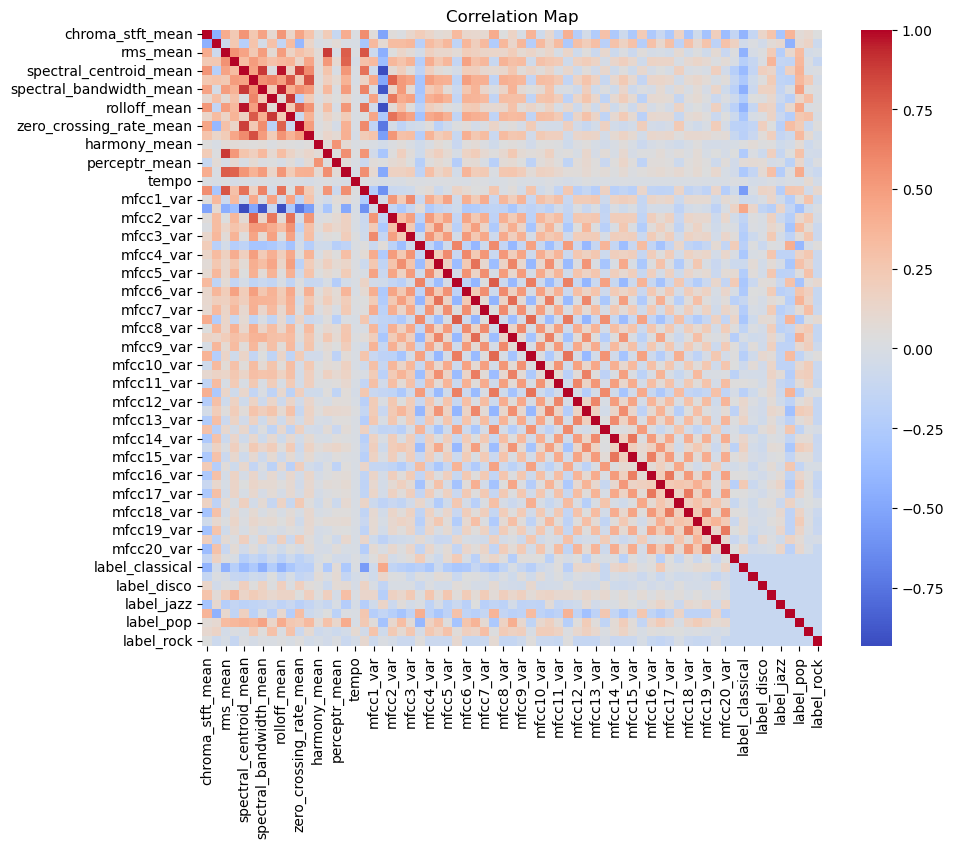

In [7]:
# Generate correlation map 
plt.figure(figsize=(10, 8))
sns.heatmap(df_encoded.corr(), annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Map')
plt.show()

Correlation between features and genre labels seems generally weak.

# XGBoost

In [8]:
# Create initial XGBoost binary classifier using logistic loss as the objective function
xgb_base = xgb.XGBClassifier(objective='binary:logistic')

# Create multiclass classification-enabled model
multilabel_model = MultiOutputClassifier(xgb_base)

# Fit model to training data and predict testing data
multilabel_model.fit(X_train, y_train)
y_pred = multilabel_model.predict(X_test)

# Report metrics
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))

Accuracy: 0.7932932932932933
              precision    recall  f1-score   support

           0       0.93      0.75      0.83       208
           1       0.96      0.98      0.97       203
           2       0.93      0.73      0.82       186
           3       0.97      0.76      0.85       199
           4       0.97      0.79      0.87       218
           5       0.96      0.84      0.90       192
           6       0.96      0.91      0.93       204
           7       0.97      0.89      0.93       180
           8       0.95      0.79      0.87       211
           9       0.94      0.62      0.75       197

   micro avg       0.96      0.81      0.87      1998
   macro avg       0.96      0.81      0.87      1998
weighted avg       0.96      0.81      0.87      1998
 samples avg       0.97      0.81      0.80      1998



# AdaBoost

In [9]:
# Cast encoded label data to 1d arrays
y_train_1d = np.argmax(y_train, axis=1)
y_test_1d = np.argmax(y_test, axis=1)

 # Create a shallow decision tree classifier tree
tree_clf = DecisionTreeClassifier(max_depth=1)

# Create AdaBoost classifier with decision tree as base estimator
ada_clf = AdaBoostClassifier(base_estimator=tree_clf, n_estimators=50, learning_rate=1)

# Fit model to training data and predict testing data
ada_clf.fit(X_train, y_train_1d)
y_pred = ada_clf.predict(X_test)

# Report metrics
accuracy = accuracy_score(y_test_1d, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test_1d, y_pred, zero_division=1))

Accuracy: 0.49099099099099097
              precision    recall  f1-score   support

           0       0.39      0.55      0.46       208
           1       0.85      0.81      0.83       203
           2       0.39      0.24      0.29       186
           3       0.48      0.24      0.32       199
           4       0.39      0.39      0.39       218
           5       0.48      0.53      0.50       192
           6       0.59      0.82      0.68       204
           7       0.47      0.87      0.61       180
           8       0.48      0.34      0.40       211
           9       0.29      0.16      0.21       197

    accuracy                           0.49      1998
   macro avg       0.48      0.49      0.47      1998
weighted avg       0.48      0.49      0.47      1998



# KNN

In [10]:
# Initialize PCA and KNN models
pca = PCA(n_components=0.95)
knn = KNeighborsClassifier(algorithm='kd_tree', n_jobs=-1)

# Create pipeline for GridSearch
pipeline = IMBPipeline([
    ('smote', SMOTE(random_state=42)),  # Apply SMOTE for oversampling
    ('pca', pca),  # PCA to attempt feature dimensionality reduction
    ('knn', knn)
])

# Possible parameters for GridSearch
param_grid = {
    'knn__n_neighbors': [3, 5, 7],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

# Apply GridSearch to find best hyperparamters for KNN
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Extract best model and predict testing data
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Report metrics
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [ ]:
# Report best parameters of model
best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'knn__metric': 'euclidean', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}


In [ ]:
# Create optimized KNN w/ best parameters
optimized_pipeline = IMBPipeline([('smote', SMOTE(random_state=42)),
    ('pca', PCA(n_components=0.95)),
    ('knn', KNeighborsClassifier(
        n_neighbors=3, 
        weights='distance', 
        metric='euclidean', 
        algorithm='kd_tree', 
        n_jobs=-1))
])

# Fit model to training data and predict testing data
optimized_pipeline.fit(X_train, y_train)
y_pred = optimized_pipeline.predict(X_test)

# Report metrics
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))

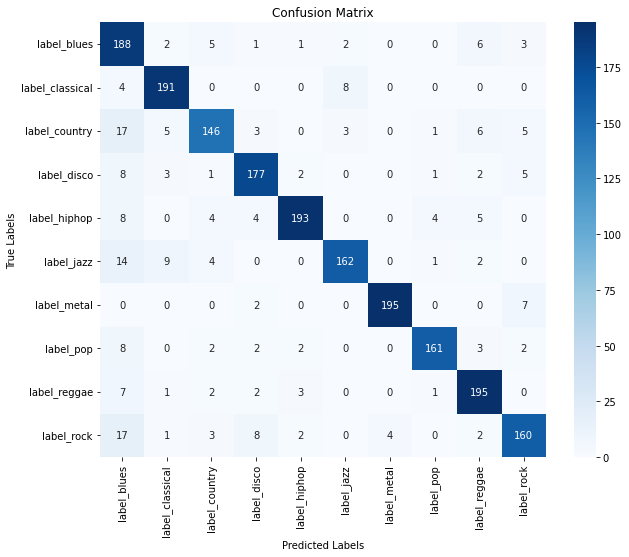

In [ ]:
conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# SVM

In [ ]:
# Initialize SVM model
svm = svm.SVC(kernel='linear', C=1)

# Fit model to training data and predict testing data
svm.fit(X_train, y_train_1d)
y_pred = svm.predict(X_test)

# Report metrics
accuracy = accuracy_score(y_test_1d, y_pred)
print('Accuracy for SVM: ', accuracy)
print("Classification Report:\n", classification_report(y_test_1d, y_pred))

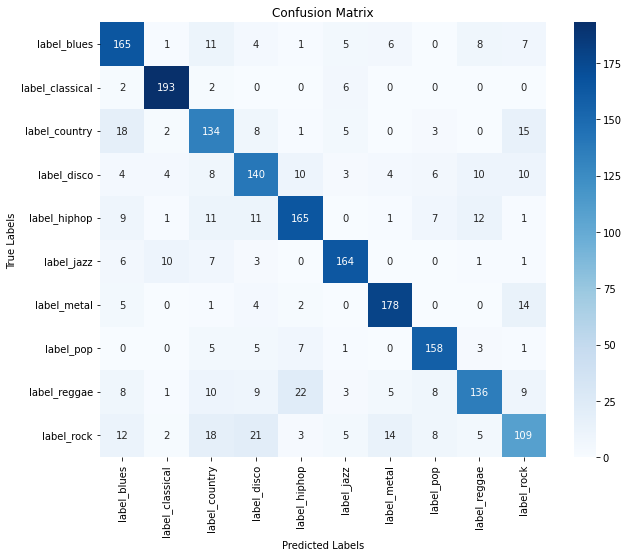

In [ ]:
conf_matrix = confusion_matrix(y_test_1d, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
xgb_probs = np.array(multilabel_model.predict_proba(X_test))
knn_probs = np.array(optimized_pipeline.predict_proba(X_test))

xgb_probs = np.array(xgb_probs)
knn_probs = np.array(knn_probs)

# Combine probabilities using simple averaging
ensemble_probs = (xgb_probs + knn_probs) / 2

In [ ]:
for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
    ensemble_binary_predictions = (ensemble_probs >= threshold).astype(int)

    # Ensure binary predictions have the correct shape
    ensemble_binary_predictions = ensemble_binary_predictions[:, :, 1]  # Assuming you're interested in class 1 predictions

    # Convert binary predictions to class labels
    ensemble_majority_predictions = np.mean(ensemble_binary_predictions, axis=0)
    ensemble_majority_predictions = (ensemble_majority_predictions >= 0.5).astype(int)

    # Calculate the accuracy score
    ensemble_accuracy = accuracy_score(y_test_1d, ensemble_majority_predictions)
    print(f"Ensemble Accuracy ({threshold}):", ensemble_accuracy)

Ensemble Accuracy: 0.1041041041041041


In [ ]:
print("Shape of XGBoost probabilities:", xgb_probs.shape)
print("Shape of KNN probabilities:", knn_probs.shape)

# Check if probabilities are within the valid range
print("Minimum probability:", np.min(ensemble_probs))
print("Maximum probability:", np.max(ensemble_probs))

Shape of XGBoost probabilities: (10, 1998, 2)
Shape of KNN probabilities: (10, 1998, 2)
Minimum probability: 3.984926877365069e-08
Maximum probability: 0.9999999701976776


In [ ]:
# Ensure consistent data formats
print("Shape of X_test:", X_test.shape)
print("Shape of y_test_labels:", y_test_labels.shape)

# Verify binary predictions
print("Shape of ensemble_binary_predictions:", ensemble_binary_predictions.shape)

# Check probability ranges
print("Minimum probability:", np.min(ensemble_probs))
print("Maximum probability:", np.max(ensemble_probs))

# Threshold probabilities to obtain binary predictions
threshold = 0.5
ensemble_binary_predictions = (ensemble_probs >= threshold).astype(int)

# Verify binary predictions after thresholding
print("Shape of thresholded ensemble_binary_predictions:", ensemble_binary_predictions.shape)

# Convert binary predictions to class labels
ensemble_majority_predictions = np.argmax(np.mean(ensemble_binary_predictions, axis=0), axis=1)

# Calculate the accuracy score
ensemble_accuracy = accuracy_score(y_test_labels, ensemble_majority_predictions)
print("Ensemble Accuracy:", ensemble_accuracy)

Shape of X_test: (1998, 57)
Shape of y_test_labels: (1998,)
Shape of ensemble_binary_predictions: (10, 1998, 2)
Minimum probability: 3.984926877365069e-08
Maximum probability: 0.9999999701976776
Shape of thresholded ensemble_binary_predictions: (10, 1998, 2)
Ensemble Accuracy: 0.1041041041041041


In [ ]:
print("Shape of ensemble_majority_predictions:", ensemble_majority_predictions.shape)
print("Shape of y_test_labels:", y_test_labels.shape)

# Print the first few elements of ensemble_majority_predictions and y_test_labels
print("First few elements of ensemble_majority_predictions:", ensemble_majority_predictions[:10])
print("First few elements of y_test_labels:", y_test_labels[:10])

Shape of ensemble_majority_predictions: (1998,)
Shape of y_test_labels: (1998,)
First few elements of ensemble_majority_predictions: [0 0 0 0 0 0 0 0 0 0]
First few elements of y_test_labels: [4 5 0 0 6 9 7 2 2 0]
